### Group 7

This end-to-end pipeline includes the following elements:

* Experimental setup 

* Data preprocessing

* Model Selection

* Model Evaluation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import missingno as msno
import time
import lightgbm as ltb
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [9]:
filepath = os.getcwd()

### Function Definitions

In [10]:
def label_encoder(df,cols):
    """iterates over list of cols
       transforming each col within 
       a dataframe of only categorical columns
       to a numerical value
       args: a dataframe with only categorical features 
       and a list of col names
       output: the df given as input is returned
       with the numerical transformations of each categorical
    """
    for col in cols:
        df[col] = df[col].astype('category').cat.codes
    return(df)

In [11]:
def impute_indicator(df_train,df_test,strategy_num='mean',strategy_cat='most_frequent',with_indicators=False):
    """
    imputes missing values within DataFrames,
    with two distinct imputation strategies
    for numerical and categorical cols.
    Params: train and test DataFrames, string value for numeric
    impuation strategy, string value for categorical
    imputation strategy, boolean value to indicate
    whether a imputation indication column
    should be concatenated to the DataFrame.
    returns: imputed train and test DataFrames
    """
    cols_with_missings_train = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
    
    cols_with_missings_test = [col for col in df_test.columns if df_test[col].isnull().sum() > 0]
    # Create an indicator column for columns that were imputed
    
    if with_indicators == True:
        indicators_train = df_train[cols_with_missings_train].isnull().astype(int).add_suffix('_indicator')
        indicators_test =  df_test[cols_with_missings_test].isnull().astype(int).add_suffix('_indicator')
    
        df_train = pd.concat([df_train,indicators_train],axis=1)
        df_test = pd.concat([df_test,indicators_test],axis=1)
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy=strategy_num)
    imp_freq = SimpleImputer(missing_values=np.nan, strategy=strategy_cat)
    

    for col in df_train[cols_with_missings_train].columns:
        if df_train[col].dtype == 'object':
            imp_freq=imp_freq.fit(df_train[[col]])
            df_train[col] = imp_freq.transform(df_train[[col]])
        else:
            imp_mean=imp_mean.fit(df_train[[col]])
            df_train[col] = imp_mean.transform(df_train[[col]])
    
    for col in df_test[cols_with_missings_test].columns:
        if df_test[col].dtype == 'object':
            imp_freq=imp_freq.fit(df_test[[col]])
            df_test[col] = imp_freq.transform(df_test[[col]])
        else:
            imp_mean=imp_mean.fit(df_test[[col]])
            df_test[col] = imp_mean.transform(df_test[[col]])

    return df_train, df_test

In [12]:
def ordinal_encoder(df, col, order):
    """
    This function uses cat.codes 
    encoding but label mappings are determined
    using a predetermined order.
    Params: DataFrame, column of DataFrame 
    to be encoded, list object with ordered
    categorical labels.
    """
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

In [13]:
# Some of the code from this function was inspired and adapted form the following source: 
# https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
def hybrid_encoder(df_train, df_test):
    """
    This function returns two dataframes which have been 
    encoded with a combination of label, ordinal, and dummy encodings.
    params: train and test dataframes
    """
    # Label encode categorical variables.

    label_encoder = LabelEncoder()
    mappings = []

    # Desired label orders for categorical columns.
    education_levels_ordered = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
    month_ordered = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    weekdays_ordered = ['mon', 'tue', 'wed', 'thu', 'fri']

    # Dummy variables for high-cardinality categoricals 
    df_train = pd.concat([df_train, pd.get_dummies(df_train['job'])],axis=1)
    df_train.drop(columns=['job'],inplace=True)

    # Use ordered cat.codes for days, months, and education
    ordinal_encoder(df_train, 'education', education_levels_ordered)
    ordinal_encoder(df_train, 'month', month_ordered)
    ordinal_encoder(df_train, 'day_of_week', weekdays_ordered)

    # Same label encoding for rest since low cardinality
    for i, col in enumerate(df_train):
        if df_train[col].dtype == 'object':
            df_train[col] = label_encoder.fit_transform(np.array(df_train[col].astype(str)).reshape((-1,)))
            df_test[col] = label_encoder.transform(np.array(df_test[col].astype(str)).reshape((-1,)))
            mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

    # Desired label orders for categorical columns.
    education_levels_ordered = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
    month_ordered = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    weekdays_ordered = ['mon', 'tue', 'wed', 'thu', 'fri']

    # Dummy variables for high-cardinality categoricals 
    df_test = pd.concat([df_test, pd.get_dummies(df_test['job'])],axis=1)
    df_test.drop(columns=['job'],inplace=True)

    # Use ordered cat.codes for days, months, and education
    ordinal_encoder(df_test, 'education', education_levels_ordered)
    ordinal_encoder(df_test, 'month', month_ordered)
    ordinal_encoder(df_test, 'day_of_week', weekdays_ordered)
    
    return(df_train,df_test)

In [14]:
def compare_models(model_names,preds_train,preds_test,y_test,y_val):
    """This function makes evaluates predictions for a list of models, 
    scores the models using AUC, and returns a dataframe with the class 
    an AUC for each model and its predictions.
    Args: A list of model variables, a list of corresponding prediction values, and a list of model names in string form. 
    """
    scoring_df_1 = pd.DataFrame()
    scoring_df_2 = pd.DataFrame()
    for ind, mod in enumerate(model_names):
        # Train
        fpr_train, tpr_train, thresholds = metrics.roc_curve(y_test, preds_train[ind], pos_label=1)
        model_auc_train = metrics.auc(fpr_train, tpr_train)
        # Test
        fpr_test, tpr_test, thresholds = metrics.roc_curve(y_val, preds_test[ind], pos_label=1)
        model_auc_test = metrics.auc(fpr_test, tpr_test)
        scoring_df_1[model_names[ind]] = [round(model_auc_train,2)]
        scoring_df_2[model_names[ind]] = [round(model_auc_test,2)]
    scoring_df_final = pd.concat([scoring_df_1,scoring_df_2],axis=0)
    scoring_df_final.index = ['Train AUC','Test AUC']
    return(scoring_df_final)

### Pipeline Control Flow

In [15]:
# Preprocessing

# Use label encoding code
label_encoding = True 

# Use imputation function
impute_indicate = True

# Impute missing categorical variables as 'missing'
impute_missing = False

# Use one-hot-encoding code
one_hot_encoding = False

# Use feature engineering code
feature_engineering=False

# Run forward-stepwise feature selection
feature_selection_fsws=False

# Apply ordinal encoding for ordinal categoricals and get dummies for high-cardinality categoricals
hybrid_categorical_encoding=False

# Apply recursive feature elimination with random forest
rfecv_rf=False

In [16]:
df_train = pd.read_csv("../data/bank_mkt_train.csv")

In [17]:
df_train.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


In [18]:
df_test = pd.read_csv("../data/bank_mkt_test.csv")

In [19]:
df_test.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,2986,53.0,technician,single,professional.course,no,no,no,cellular,jul,tue,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
1,29710,32.0,blue-collar,married,basic.6y,no,yes,no,telephone,jul,wed,2.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
2,38938,70.0,retired,married,high.school,no,yes,no,cellular,aug,tue,1.0,999.0,0.0,nonexistent,-2.9,92.201,-31.4,0.883,5076.2
3,31313,46.0,services,married,high.school,no,no,no,cellular,apr,mon,1.0,999.0,1.0,failure,-1.8,93.075,-47.1,1.405,5099.1
4,24173,35.0,technician,single,unknown,no,no,no,cellular,may,thu,1.0,999.0,1.0,failure,-1.8,92.893,-46.2,1.266,5099.1


### EDA

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       20000 non-null  int64  
 1   age             19798 non-null  float64
 2   job             19839 non-null  object 
 3   marital         19801 non-null  object 
 4   education       19830 non-null  object 
 5   default         19786 non-null  object 
 6   housing         19805 non-null  object 
 7   loan            19781 non-null  object 
 8   contact         19783 non-null  object 
 9   month           19801 non-null  object 
 10  day_of_week     19815 non-null  object 
 11  campaign        19797 non-null  float64
 12  pdays           19815 non-null  float64
 13  previous        19791 non-null  float64
 14  poutcome        19825 non-null  object 
 15  emp.var.rate    19835 non-null  float64
 16  cons.price.idx  19819 non-null  float64
 17  cons.conf.idx   19803 non-null 

In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       10000 non-null  int64  
 1   age             9895 non-null   float64
 2   job             9889 non-null   object 
 3   marital         9905 non-null   object 
 4   education       9903 non-null   object 
 5   default         9876 non-null   object 
 6   housing         9897 non-null   object 
 7   loan            9891 non-null   object 
 8   contact         9913 non-null   object 
 9   month           9880 non-null   object 
 10  day_of_week     9894 non-null   object 
 11  campaign        9912 non-null   float64
 12  pdays           9900 non-null   float64
 13  previous        9895 non-null   float64
 14  poutcome        9895 non-null   object 
 15  emp.var.rate    9895 non-null   float64
 16  cons.price.idx  9899 non-null   float64
 17  cons.conf.idx   9896 non-null   

<AxesSubplot:>

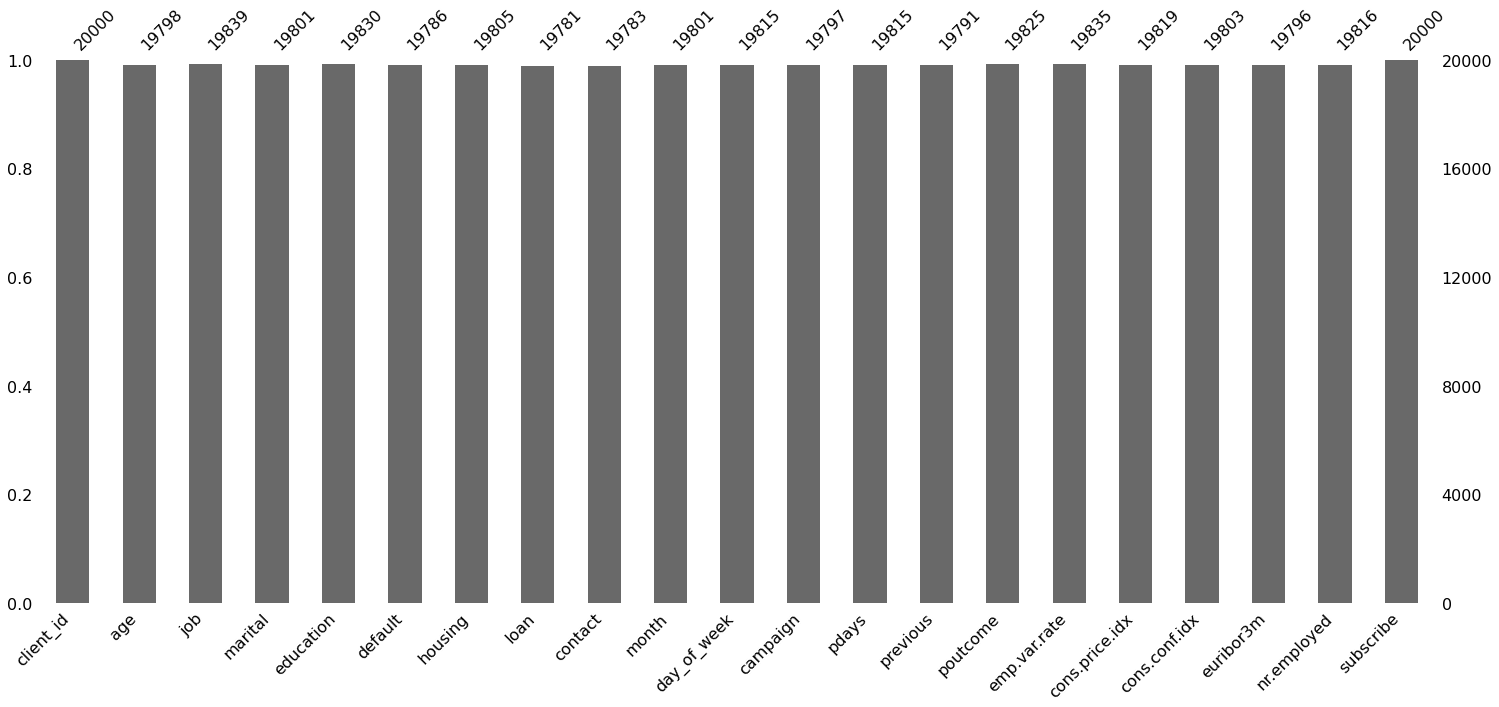

In [22]:
msno.bar(df_train)

<AxesSubplot:>

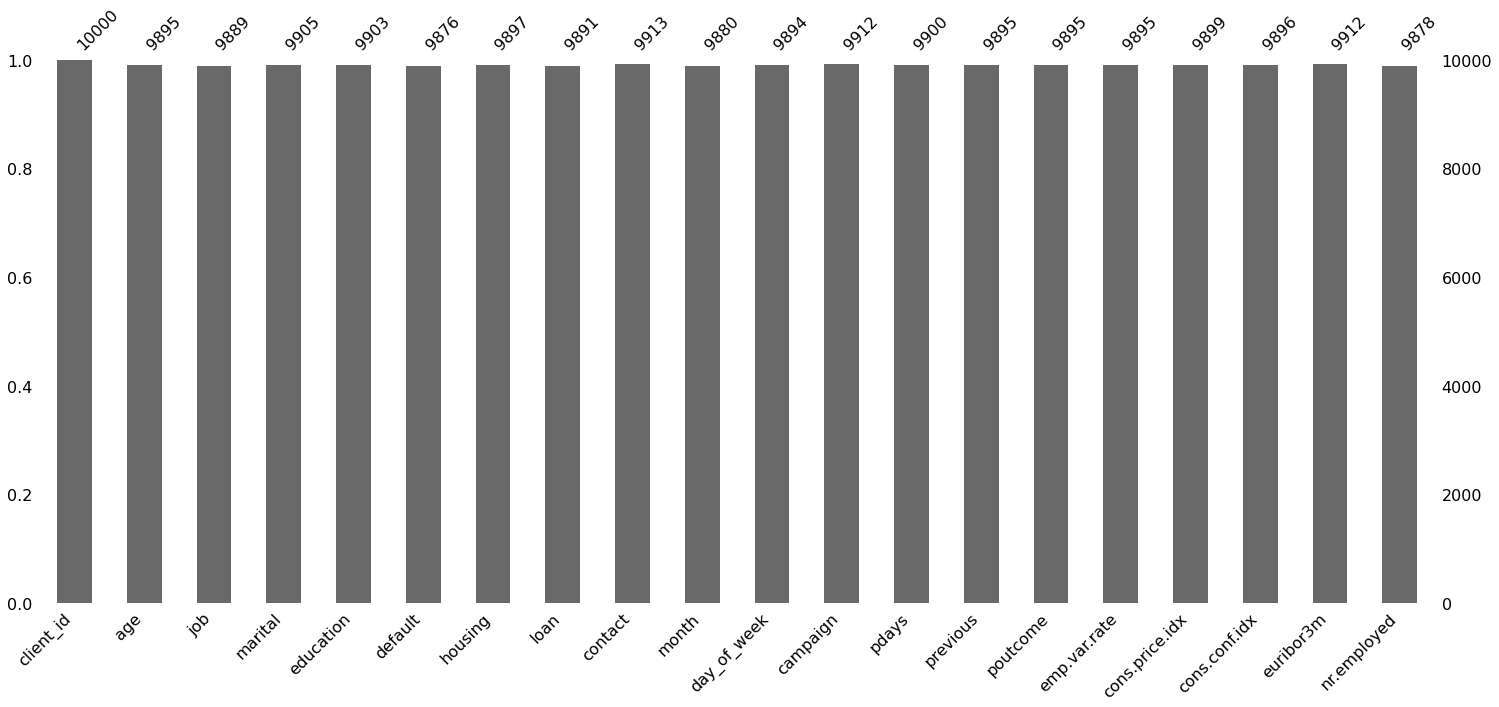

In [23]:
msno.bar(df_test)

In [24]:
df_train.dtypes

client_id           int64
age               float64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign          float64
pdays             float64
previous          float64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
subscribe           int64
dtype: object

In [25]:
# List comprehension categoricals
cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']

# List comprehension numerics
numeric_cols = [col for col in df_train.columns if col not in cat_cols and col != 'subscribe']

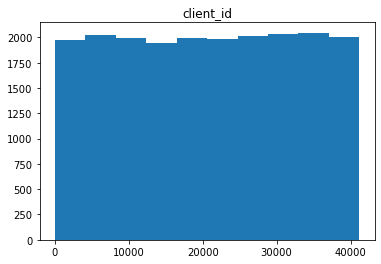

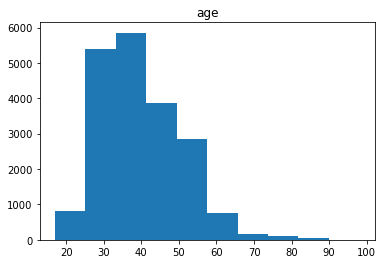

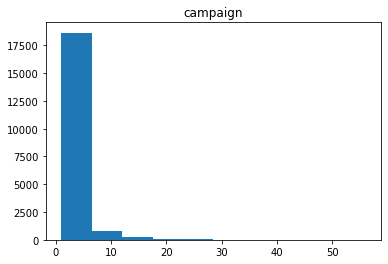

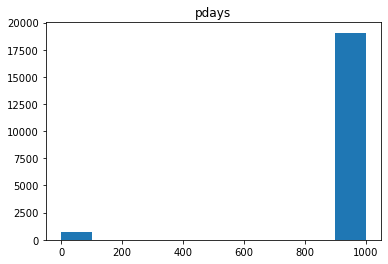

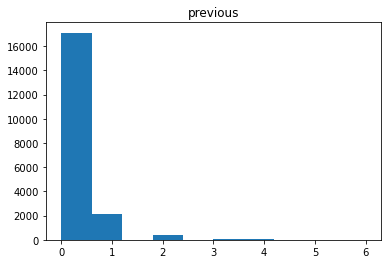

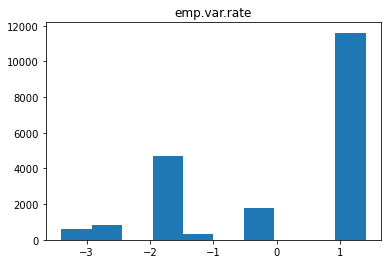

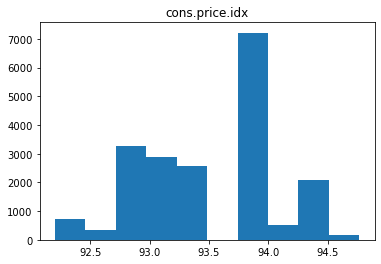

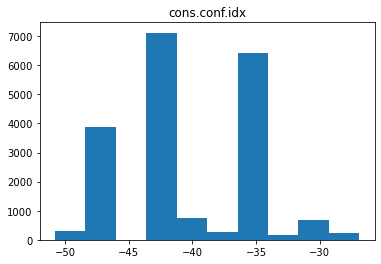

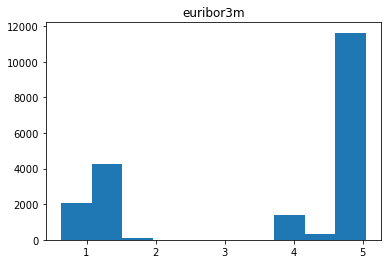

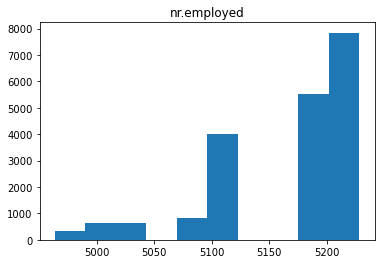

In [26]:
# Examine feature distributions

for col in numeric_cols:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show()

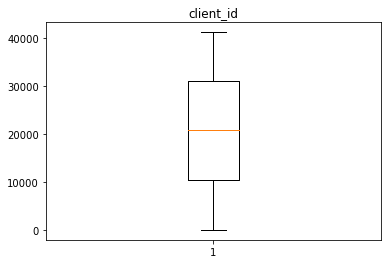

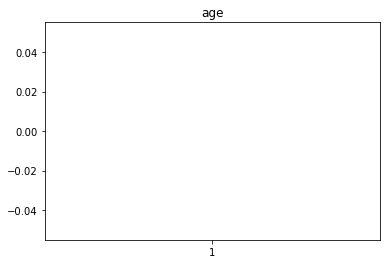

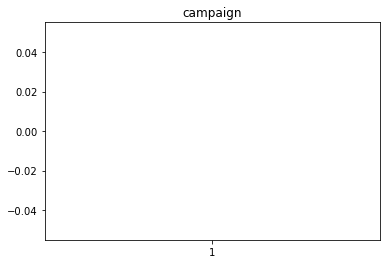

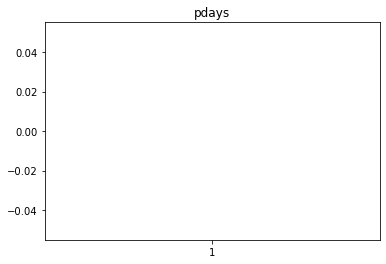

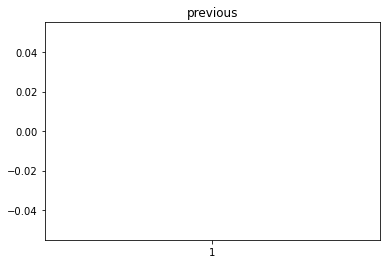

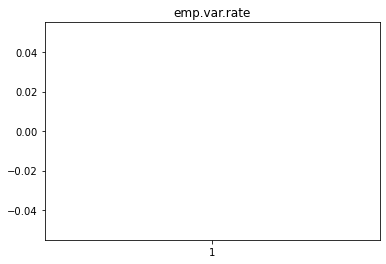

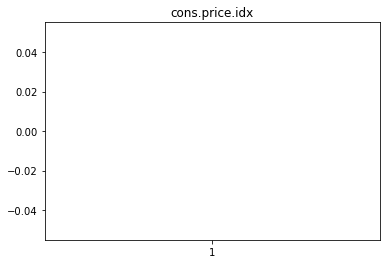

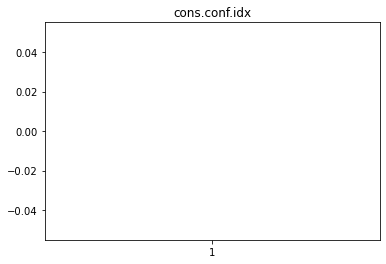

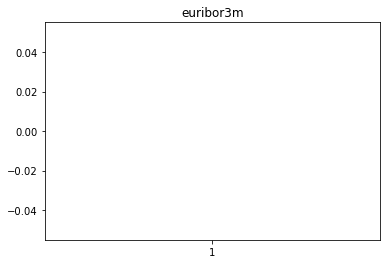

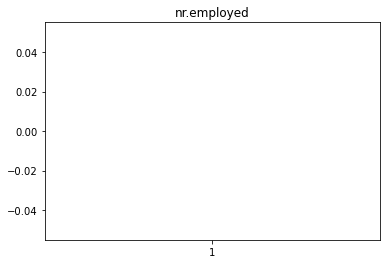

In [27]:
for col in numeric_cols:
    plt.boxplot(df_train[col])
    plt.title(col)
    plt.show()

In [28]:
df_train.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


In [29]:
if feature_engineering == True:
    print('ran')
    # Discretize age column
    df_train['age_quantiles'] = pd.qcut(df_train['age'],
                            q=[0,.2,.4,.6,.8,1],
                            labels=False,
                            precision=0)
    # Test set
    df_test['age_quantiles'] = pd.qcut(df_test['age'],
                            q=[0,.2,.4,.6,.8,1],
                            labels=False,
                            precision=0)

    # Create P_Months column using the Pdays column
    df_train['P_months'] = df_train['pdays']/12

    # Create P_Months column using the Pdays column
    df_test['P_months'] = df_test['pdays']/12

In [30]:
df_train.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


In [31]:
if impute_missing == True:
    print('ran')
    df_train[cat_cols] = df_train[cat_cols].fillna('Missing')
    df_test[cat_cols] = df_test[cat_cols].fillna('Missing')
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean=imp_mean.fit(df_train[numeric_cols])
    df_train[numeric_cols] = imp_mean.transform(df_train[numeric_cols])
    imp_mean=imp_mean.fit(df_test[numeric_cols])
    df_test[numeric_cols] = imp_mean.transform(df_test[numeric_cols])

In [32]:
if label_encoding == True:
    print('ran')
    df_train = label_encoder(df_train,cat_cols)
    df_test = label_encoder(df_test,cat_cols)

ran


In [33]:
if one_hot_encoding == True:
    print('ran')
    #train
    one_hot_encoder = OneHotEncoder(sparse=False)
    train_encoded = one_hot_encoder.fit_transform(df_train[cat_cols])
    train_encoded = pd.DataFrame(train_encoded)
    train_encoded.columns = one_hot_encoder.get_feature_names_out()
    df_train.drop(columns=cat_cols,inplace=True)
    df_train = pd.concat([df_train,train_encoded],axis=1).reset_index()
    #test
    test_encoded = one_hot_encoder.transform(df_test[cat_cols])
    test_encoded = pd.DataFrame(test_encoded)
    test_encoded.columns = one_hot_encoder.get_feature_names_out()
    df_test.drop(columns=cat_cols,inplace=True)
    df_test = pd.concat([df_test,test_encoded],axis=1).reset_index()

In [34]:
df_train.columns

Index(['client_id', 'age', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribe'],
      dtype='object')

In [35]:
if hybrid_categorical_encoding == True:
    print('ran')
    df_train,df_test = hybrid_encoder(df_train,df_test)

In [36]:
if impute_indicate == True:
    print('ran')
    df_train, df_test = impute_indicator(df_train,df_test)

ran


In [37]:
# Export basetable to csv
df_train.to_csv('basetable_train.csv')
df_test.to_csv('basetable_test.csv')

In [38]:
X = df_train[[col for col in df_train.columns if col != 'subscribe']]
y = df_train.subscribe

In [39]:
if rfecv_rf == True:
    print('ran')
    rf_clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                           min_samples_split=20, n_estimators=557)  

    rfecv_rf = RFECV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
          estimator=rf_clf, scoring='AUC')

    rfecv_rf.fit(X,y)

    print("Optimal number of features: %d" % rfecv_rf.n_features_)

    # Plot code sourced from: https://practicaldatascience.co.uk/machine-learning/how-to-use-recursive-feature-elimination-in-your-models
    plt.figure(figsize=(10, 5))
    plt.title('Number of features selected vs 10-Fold cross-validated accuracy')
    plt.xlabel('Number of features')
    plt.ylabel('accuracy')
    plt.plot(range(0, len(rfecv_rf.grid_scores_)), rfecv_rf.grid_scores_)
    plt.show()
    
    # Subset X to only contain selected features
    optimal_features = rfecv_rf.get_support(1)
    X = df_train[df_train.columns[optimal_features]]

In [40]:
# Training and remaining split
X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size=0.4)

# Validation split
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem,test_size=0.5)

In [41]:
#subset train set for important cols based on correlation analysis 
X_train_full = df_train[[col for col in X.columns]]
y_train_full = df_train.subscribe

In [42]:
#test set as well - dv subscribe
X_test_full = df_test[[col for col in X.columns]]

## Random Forest Classifier

In [391]:
%%time 
# Some of the code within the param_grid was adapted from here: 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

rf = RandomForestClassifier()
# create parameter dictionary 
param_grid = {'bootstrap': [True, False],
              'criterion': ['gini','entropy'],
                'max_depth': [int(x) for x in np.linspace(10, 110, num = 20)],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4, 6, 10],
                'min_samples_split': [5, 10, 15, 20, 25],
                'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2500, num = 20)]}
#initiate grid search
grid = RandomizedSearchCV(rf,param_grid,
                          n_iter=100,
                          random_state=123,
                          verbose=3,
                          cv=5)
#fit train data

grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=731;, score=0.898 total time=   6.1s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=731;, score=0.906 total time=   5.9s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=731;, score=0.897 total time=   5.8s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=731;, score=0.898 total time=   5.8s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=88, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=731;, score=0.905 total time=   5.7s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=52, max_features=auto, min_sa

[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=36, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1615;, score=0.896 total time=  20.4s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=36, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1615;, score=0.902 total time=  20.1s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=88, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1236;, score=0.898 total time=  12.2s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=88, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1236;, score=0.905 total time=  12.4s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=88, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1236;, score=0.896 total time=  12.3s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=88, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=

[CV 2/5] END bootstrap=False, criterion=entropy, max_depth=78, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=226;, score=0.906 total time=   3.0s
[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=78, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=226;, score=0.893 total time=   3.0s
[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=78, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=226;, score=0.897 total time=   3.1s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=78, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=226;, score=0.902 total time=   3.0s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=36, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=984;, score=0.896 total time=  12.6s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=36, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=9

[CV 5/5] END bootstrap=True, criterion=gini, max_depth=52, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1110;, score=0.905 total time=   9.4s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1615;, score=0.899 total time=  12.6s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1615;, score=0.906 total time=  12.8s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1615;, score=0.897 total time=  12.7s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1615;, score=0.897 total time=  12.8s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1615;, score

[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=83, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=1868;, score=0.895 total time=  23.2s
[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=83, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=1868;, score=0.897 total time=  23.7s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=83, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=1868;, score=0.902 total time=  23.3s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=57, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1363;, score=0.897 total time=  11.5s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=57, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1363;, score=0.908 total time=  11.5s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=57, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=136

[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=31, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1868;, score=0.896 total time=  21.7s
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=31, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1868;, score=0.906 total time=  17.5s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=31, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1868;, score=0.896 total time=  19.5s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=31, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1868;, score=0.898 total time=  19.6s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=31, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1868;, score=0.904 total time=  16.7s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=99, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimato

[CV 4/5] END bootstrap=True, criterion=gini, max_depth=52, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=984;, score=0.898 total time=   8.0s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=52, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=984;, score=0.905 total time=   7.9s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=94, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=857;, score=0.896 total time=   8.3s
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=94, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=857;, score=0.907 total time=   8.3s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=94, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=857;, score=0.895 total time=   7.7s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=94, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=857;,

[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1236;, score=0.907 total time=  11.5s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1236;, score=0.895 total time=  12.0s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1236;, score=0.899 total time=  12.2s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1236;, score=0.905 total time=  11.3s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=94, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=2121;, score=0.897 total time=  23.3s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=94, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimator

[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=67, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=478;, score=0.904 total time=   7.1s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=57, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=984;, score=0.899 total time=   7.5s
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=57, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=984;, score=0.905 total time=   7.8s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=57, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=984;, score=0.898 total time=   7.6s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=57, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=984;, score=0.899 total time=   7.8s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=57, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_esti

[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=94, max_features=sqrt, min_samples_leaf=1, min_samples_split=25, n_estimators=352;, score=0.896 total time=   4.3s
[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=94, max_features=sqrt, min_samples_leaf=1, min_samples_split=25, n_estimators=352;, score=0.898 total time=   5.2s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=94, max_features=sqrt, min_samples_leaf=1, min_samples_split=25, n_estimators=352;, score=0.903 total time=   4.5s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=2247;, score=0.898 total time=  16.9s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=2247;, score=0.906 total time=  16.7s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=

[CV 1/5] END bootstrap=False, criterion=gini, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2500;, score=0.898 total time=  31.7s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2500;, score=0.905 total time=  33.1s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2500;, score=0.896 total time=  31.7s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2500;, score=0.896 total time=  32.4s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2500;, score=0.901 total time=  32.5s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=83, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1615;, 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 20, 25, 31, 36,
                                                      41, 46, 52, 57, 62, 67,
                                                      73, 78, 83, 88, 94, 99,
                                                      104, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [100, 226, 352, 478,
                                                         605, 731, 857, 984,
                                    

In [392]:
print(grid.best_params_)
print(grid.best_estimator_)

{'n_estimators': 1994, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 99, 'criterion': 'gini', 'bootstrap': True}
RandomForestClassifier(max_depth=99, min_samples_leaf=10, min_samples_split=25,
                       n_estimators=1994)


Below are previously used hyperparameters: 

{'n_estimators': 733,
 'min_samples_split': 20,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

{'n_estimators': 557, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 46, 'bootstrap': True}
RandomForestClassifier(max_depth=46, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=20, n_estimators=557)
                       
{'n_estimators': 557, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=557)             

{'n_estimators': 1994, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 99, 'criterion': 'gini', 'bootstrap': True}
RandomForestClassifier(max_depth=99, min_samples_leaf=10, min_samples_split=25,
                       n_estimators=1994)

In [45]:
if list(set(X_train.columns) - set( X_test.columns)) != []:
    X_train_full.drop(columns=['default_yes'],inplace=True)
    X_train.drop(columns=['default_yes'],inplace=True)

In [56]:
#clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6, min_samples_split=20, n_estimators=557,random_state=123)

rf_clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=557,random_state=123)             



rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=557,
                       random_state=123)

In [163]:
feature_importances = rf_clf.feature_importances_

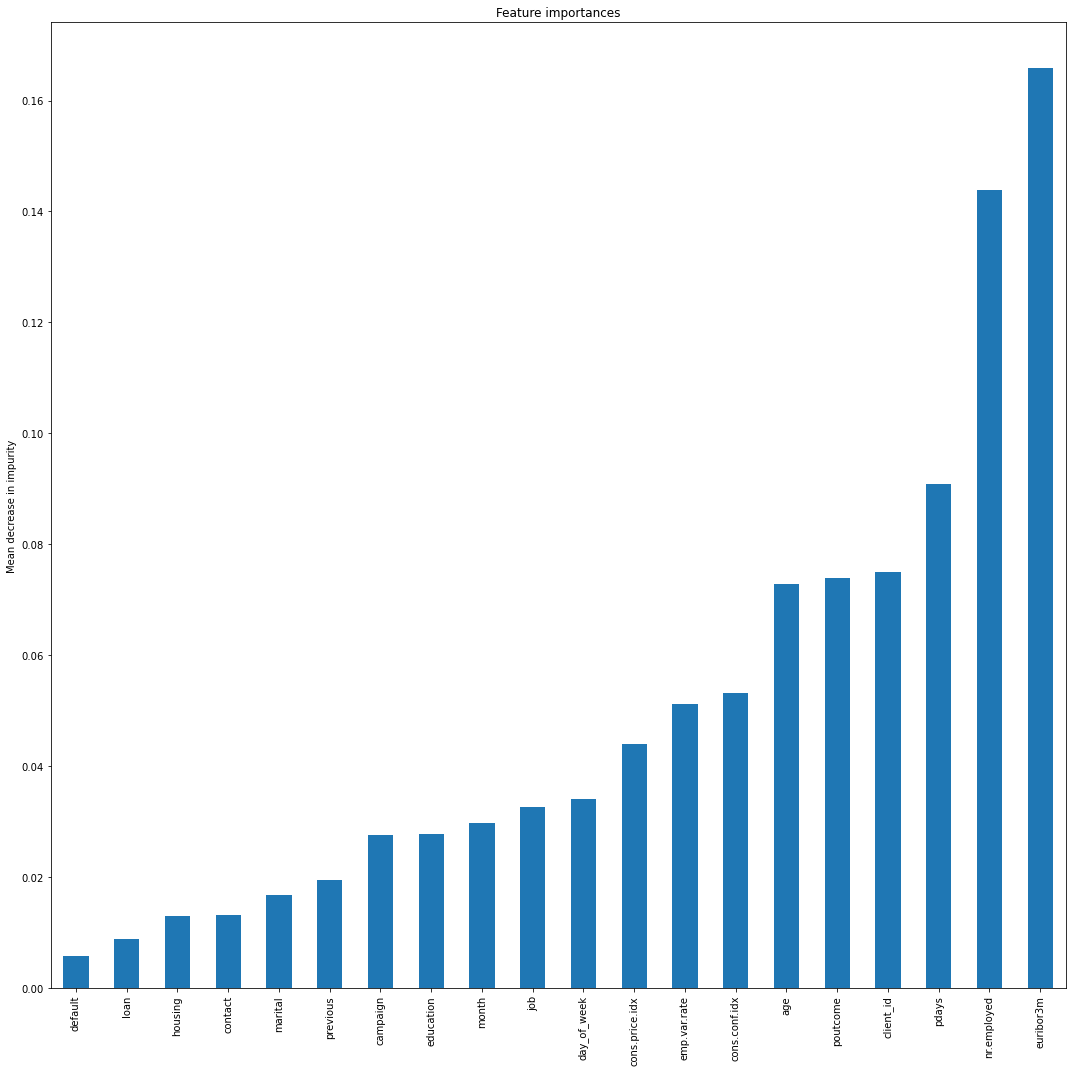

In [164]:
# Code source: 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
forest_importances = pd.Series(feature_importances, index=X_train.columns.to_list())

fig, ax = plt.subplots(figsize=(15,15))
forest_importances = forest_importances.sort_values()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [57]:
clf_train_preds = rf_clf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_train_preds, pos_label=1)

AUC_train_clf = metrics.auc(fpr, tpr)

clf_test_preds = rf_clf.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, clf_test_preds, pos_label=1)

AUC_test_clf = metrics.auc(fpr, tpr)

print(f'Train AUC: %.5f, Test AUC: %.5f'% (AUC_train_clf,AUC_test_clf))

Train AUC: 0.77745, Test AUC: 0.78251


## AdaBoost Classifier

In [412]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

param_grid = {'base_estimator__max_depth':[i for i in range(2,20,2)],
              'base_estimator__min_samples_leaf':[i for i in range(1,20,2)],
              'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 3000, num = 20)],
              'learning_rate':[0.01,0.05,0.1]}

grid = RandomizedSearchCV(abc,param_grid,
                          n_iter=50,
                          random_state=123,
                          verbose=3,
                          cv=3)


grid.fit(X_train_full,y_train_full)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END base_estimator__max_depth=12, base_estimator__min_samples_leaf=19, learning_rate=0.1, n_estimators=405;, score=0.887 total time=  27.1s
[CV 2/3] END base_estimator__max_depth=12, base_estimator__min_samples_leaf=19, learning_rate=0.1, n_estimators=405;, score=0.894 total time=  29.2s
[CV 3/3] END base_estimator__max_depth=12, base_estimator__min_samples_leaf=19, learning_rate=0.1, n_estimators=405;, score=0.893 total time=  27.3s


KeyboardInterrupt: 

In [430]:
print(grid.best_params_)
print(grid.best_estimator_)

{'n_estimators': 1778, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 13, 'base_estimator__max_depth': 2}
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=13),
                   learning_rate=0.01, n_estimators=1778)


In [59]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=13),
                   learning_rate=0.01, n_estimators=1778)

abc.fit(X_train,y_train)

abc_train_preds = abc.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, abc_train_preds, pos_label=1)

AUC_train_abc = metrics.auc(fpr, tpr)

abc_test_preds = abc.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, abc_test_preds, pos_label=1)

AUC_test_abc = metrics.auc(fpr, tpr)

print(f'Train AUC: %.5f, Test AUC: %.5f'% (AUC_train_abc,AUC_test_abc))

Train AUC: 0.78568, Test AUC: 0.78225


### Logistic Regression

In [167]:
lr = LogisticRegression()

param_grid = {'penalty': ['l1','l2'], 
              'C': [0.001,0.01,0.1,1,10,100,1000]}

grid = RandomizedSearchCV(lr,
                          param_grid,n_iter=100,
                          random_state=123,
                          verbose=3,
                          cv=5)

grid.fit(X_train_full,y_train_full)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 14 is smaller than n_iter=100. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.898 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.901 total time=   0.2s
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.895 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.900 total time=   0.1s
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.902 total time=   0.1s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 1/5] END ................C=0.01, penalty=l2;, score=0.898 total time=   0.1s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.901 total time=   0.1s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.896 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 4/5] END ................C=0.01, penalty=l2;, score=0.900 total time=   0.1s
[CV 5/5] END ................C=0.01, penalty=l2;, score=0.901 total time=   0.1s
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 1/5] END .................C=0.1, penalty=l2;, score=0.898 total time=   0.1s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.900 total time=   0.2s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .................C=0.1, penalty=l2;, score=0.896 total time=   0.1s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.901 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 5/5] END .................C=0.1, penalty=l2;, score=0.901 total time=   0.1s
[CV 1/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...................C=1, penalty=l2;, score=0.898 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 2/5] END ...................C=1, penalty=l2;, score=0.900 total time=   0.1s
[CV 3/5] END ...................C=1, penalty=l2;, score=0.896 total time=   0.2s
[CV 4/5] END ...................C=1, penalty=l2;, score=0.901 total time=   0.1s
[CV 5/5] END ...................C=1, penalty=l2;, score=0.901 total time=   0.1s
[CV 1/5] END ....................C=10, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ....................C=10, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ....................C=10, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ....................C=10, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ....................C=10, penalty=l1;, score=nan total time=   0.0s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 1/5] END ..................C=10, penalty=l2;, score=0.897 total time=   0.1s
[CV 2/5] END ..................C=10, penalty=l2;, score=0.900 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 3/5] END ..................C=10, penalty=l2;, score=0.896 total time=   0.2s
[CV 4/5] END ..................C=10, penalty=l2;, score=0.900 total time=   0.2s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 5/5] END ..................C=10, penalty=l2;, score=0.901 total time=   0.2s
[CV 1/5] END ...................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=100, penalty=l2;, score=0.897 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 2/5] END .................C=100, penalty=l2;, score=0.900 total time=   0.2s
[CV 3/5] END .................C=100, penalty=l2;, score=0.896 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 4/5] END .................C=100, penalty=l2;, score=0.900 total time=   0.2s
[CV 5/5] END .................C=100, penalty=l2;, score=0.901 total time=   0.1s
[CV 1/5] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 1/5] END ................C=1000, penalty=l2;, score=0.897 total time=   0.2s
[CV 2/5] END ................C=1000, penalty=l2;, score=0.900 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV 3/5] END ................C=1000, penalty=l2;, score=0.896 total time=   0.1s
[CV 4/5] END ................C=1000, penalty=l2;, score=0.900 total time=   0.2s
[CV 5/5] END ................C=1000, penalty=l2;, score=0.901 total time=   0.1s


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
---------------------------------------------------------------------------

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'penalty': ['l1', 'l2']},
                   random_state=123, verbose=3)

In [422]:
print(grid.best_params_)
print(grid.best_estimator_)

{'penalty': 'l2', 'C': 100}
LogisticRegression(C=100)


In [53]:
lr = LogisticRegression(C=100)

lr.fit(X_train,y_train)

lr_preds = lr.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, lr_preds, pos_label=1)

AUC_train_lr = metrics.auc(fpr, tpr)

lr_test_preds = lr.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, lr_test_preds, pos_label=1)

AUC_test_lr = metrics.auc(fpr, tpr)

print(f'Train AUC: %.5f, Test AUC: %.5f'% (AUC_train_lr,AUC_test_lr))

Train AUC: 0.76881, Test AUC: 0.77434


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [425]:
lr.fit(X_train_full,y_train_full)
lr_preds = lr.predict_proba(X_test_full)[:,1]

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Light Gradient Boosting Machine Classifier

In [73]:
lgbm_clf = ltb.LGBMClassifier(random_state=123)

param_grid = {
    'learning_rate': [0.005,0.01],
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)],
    'num_leaves': [int(x) for x in np.linspace(start = 10, stop = 80, num = 30)],
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary','cross_entropy_lambda'],
    'max_bin':[int(x) for x in np.linspace(start = 50, stop = 300, num = 5)], 
    'colsample_bytree' : [0.64, 0.65, 0.66,0.68],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [int(x) for x in np.linspace(start = 1, stop = 2.5, num = 10)],
    'reg_lambda' : [int(x) for x in np.linspace(start = 1, stop = 2.5, num = 10)],
    }

grid = RandomizedSearchCV(lgbm_clf, param_grid,n_iter=50, verbose=3, cv=4,n_jobs=-1)
# Run the grid
grid.fit(X_train_full, y_train_full)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 2, 'objective': 'binary', 'num_leaves': 36, 'n_estimators': 670, 'max_bin': 50, 'learning_rate': 0.01, 'colsample_bytree': 0.66, 'boosting_type': 'gbdt'}
0.90185


In [76]:
lgbm_clf = ltb.LGBMClassifier(colsample_bytree=0.66, learning_rate=0.01, max_bin=50,
               n_estimators=670, num_leaves=36, objective='binary',
               random_state=123, reg_alpha=2, reg_lambda=1, subsample=0.75)

# Fit 
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.66, learning_rate=0.01, max_bin=50,
               n_estimators=670, num_leaves=36, objective='binary',
               random_state=123, reg_alpha=2, reg_lambda=1, subsample=0.75)

In [77]:
lgbm_clf.fit(X_train,y_train)

lgbm_train_preds = lgbm_clf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, lgbm_train_preds, pos_label=1)

AUC_train_lgbm = metrics.auc(fpr, tpr)

lgbm_test_preds = lgbm_clf.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, lgbm_test_preds, pos_label=1)

AUC_test_lgbm = metrics.auc(fpr, tpr)

print(f'Train AUC: %.5f, Test AUC: %.5f'% (AUC_train_lgbm,AUC_test_lgbm))

Train AUC: 0.78562, Test AUC: 0.78847


In [91]:
#rf_preds = rf_clf.predict_proba(X_test_full)[:,1]
#final_df = X_test_full.copy(deep=True)
#final_df = X_test_full[['client_id']]
#final_df['subscribe'] = rf_preds

In [80]:
lgbm_preds = lgbm_clf.predict_proba(X_test_full)[:,1]
final_df = X_test_full.copy(deep=True)
final_df = X_test_full[['client_id']]
final_df['subscribe'] = lgbm_preds

/var/folders/fc/9vrqth010qgbrhv1th35kb040000gn/T/ipykernel_35074/2423666988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['subscribe'] = lgbm_preds


In [81]:
final_df.client_id = final_df.client_id.astype('int')

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [82]:
final_df.head()

,client_id,subscribe
0,2986,0.040972
1,29710,0.060142
2,38938,0.298683
3,31313,0.102686
4,24173,0.162482


In [83]:
final_df.to_csv('rf_submission22.csv',index=False)

In [78]:
df_model_comparison = compare_models(model_names=['Logistic Regression','Random Forest','AdaBoost','Light Gradient Boosting Machine Classifier'],preds_train=[lr_preds,clf_train_preds,abc_train_preds,lgbm_train_preds],preds_test=[lr_test_preds,clf_test_preds,abc_test_preds,lgbm_test_preds],y_test=y_test,y_val=y_val)

In [79]:
# Code sourced from: https://pandas.pydata.org/docs/user_guide/style.html

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

build = lambda x: pd.DataFrame(x, index=df_model_comparison.index, columns=df_model_comparison.columns)
cls1 = build(df_model_comparison.apply(highlight_max, props='cls-1 ', axis=0))
cls2 = build(df_model_comparison.apply(highlight_max, props='cls-2 ', axis=1, result_type='expand').values)
cls3 = build(highlight_max(df_model_comparison, props='cls-3 '))
df_model_comparison.style.set_table_styles([
    {'selector': '.cls-1', 'props': 'color:white;background-color:darkblue;'},
    {'selector': '.cls-2', 'props': 'color:white;background-color:pink;'},
    {'selector': '.cls-3', 'props': 'color:white;background-color:purple;'}
]).set_td_classes(cls1 + cls2 + cls3)

,Logistic Regression,Random Forest,AdaBoost,Light Gradient Boosting Machine Classifier
Train AUC,0.770000,0.780000,0.790000,0.790000
Test AUC,0.770000,0.600000,0.780000,0.790000


### ROC Curve

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


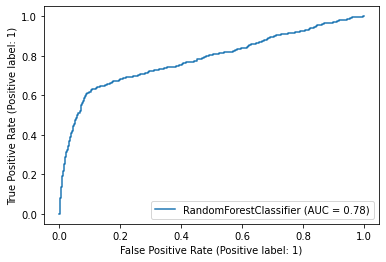

In [84]:
metrics.plot_roc_curve(rf_clf, X_val, y_val)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


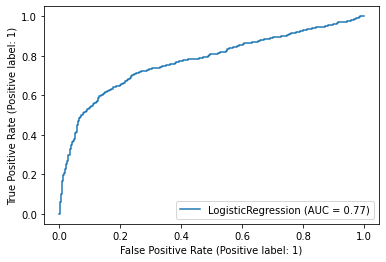

In [85]:
metrics.plot_roc_curve(lr, X_val, y_val)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


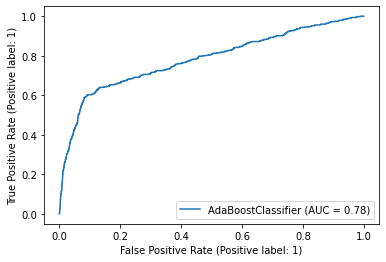

In [86]:
metrics.plot_roc_curve(abc, X_val, y_val)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


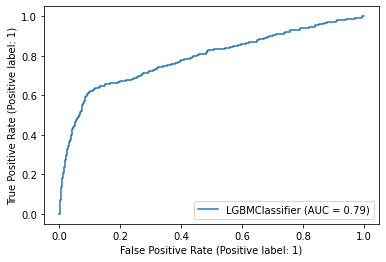

In [87]:
metrics.plot_roc_curve(lgbm_clf, X_val, y_val)

In [177]:
# Compute Classification Report 

In [89]:
from sklearn.metrics import classification_report
target_names = ['non-subscribers','subscribers']
lgbm_test_preds = lgbm_clf.predict(X_val)
print(classification_report(y_val, lgbm_test_preds,target_names=target_names))

                 precision    recall  f1-score   support

non-subscribers       0.90      0.98      0.94      3524
    subscribers       0.67      0.23      0.34       476

       accuracy                           0.90      4000
      macro avg       0.79      0.61      0.64      4000
   weighted avg       0.88      0.90      0.87      4000



## Sources:

* https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
    
* https://pandas.pydata.org/docs/user_guide/style.html
    
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74